In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# /kaggle/input/car-crash-dataset-ccd/CrashBest
# /kaggle/input/car-crash-dataset-ccd/CrashBest/C_000001_01.jpg
# /kaggle/input/crash-1500/Crash-1500/000001.mp4
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!sudo apt-get update
!sudo apt-get install ffmpeg

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]        
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [2502 kB]
Get:6 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]   
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]      
Get:8 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]      
Get:9 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [33.2 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [4548 kB]
Get:11 https://packages.cloud.google.com/apt google-fast-socket InRelease [1071 B]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/restr

In [35]:
import pandas as pd

csv_file_path = '/kaggle/input/preprocessed-df/preprocessed_df (1).csv'
annotations = pd.read_csv(csv_file_path)

class_counts = annotations['Severity of the Crash'].value_counts()
print(class_counts)

Severity of the Crash
Moderate    622
Minor       348
Severe      244
moderate     70
severe       57
minor        31
fatal        25
Fatal        18
Name: count, dtype: int64


In [36]:
annotations['Severity of the Crash'] = annotations['Severity of the Crash'].str.lower()
class_counts = annotations['Severity of the Crash'].value_counts()
print(class_counts)

Severity of the Crash
moderate    692
minor       379
severe      301
fatal        43
Name: count, dtype: int64


In [ ]:
import os
import pandas as pd

video_dir = '/kaggle/input/crash-1500/Crash-1500'
frames_dir = '/kaggle/working/frames' 

for idx, row in annotations.iterrows():
    video_number = row['Video Number']
    video_path = os.path.join(video_dir, f'{video_number:06}.mp4')
    output_dir = os.path.join(frames_dir, f'{video_number:06}')
    os.makedirs(output_dir, exist_ok=True)

    ffmpeg_command = f'ffmpeg -ss 00:00:01 -i "{video_path}" -vf fps=5 "{output_dir}/frame%04d.png"'
#     print(f"Running FFmpeg command: {ffmpeg_command}")
    os.system(ffmpeg_command)
    
    extracted_frames = os.listdir(output_dir)
    print(f"Extracted {len(extracted_frames)} frames for video {video_number}")

In [3]:
import os
frames_dir = '/kaggle/working/frames'
video_dirs = next(os.walk(frames_dir))[1]
num_videos = len(video_dirs)

print(f"Number of videos with extracted frames: {num_videos}")

Number of videos with extracted frames: 1415


In [37]:
import os
import glob
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
from PIL import Image

class VideoDataset(Dataset):
    def __init__(self, annotations_df, root_dir, transform=None, num_frames=20):
        self.annotations = annotations_df
        self.annotations['Severity of the Crash'] = self.annotations['Severity of the Crash'].str.lower()
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {'minor': 0, 'moderate': 1, 'severe': 2,'fatal': 3}
        self.num_frames = num_frames

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        video_number = self.annotations.iloc[idx]['Video Number']
        label = self.label_map[self.annotations.iloc[idx]['Severity of the Crash']]
        frame_dir = os.path.join(self.root_dir, f'{video_number:06}')
        frames = []
        # print(f"Looking for frames in: {frame_dir}")
        for frame_path in sorted(glob.glob(os.path.join(frame_dir, '*.png'))):
            frame = read_image(frame_path)
            frame = transforms.ToPILImage()(frame)

            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
        # print(f"Found {len(frames)} frames.")

        if not frames: 
            raise ValueError(f"No frames found for video {video_number} in directory {frame_dir}")
        frames = torch.stack(frames)
        return frames, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),  
])

dataset = VideoDataset(annotations_df=annotations, root_dir='/kaggle/working/frames', transform=transform)

In [38]:
import torch
from transformers import TimesformerModel, TimesformerConfig
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [39]:
class VideoClassifier(nn.Module):
    def __init__(self, num_classes, num_frames, hidden_size=512, num_layers=1, bidirectional=False, num_heads=4):
        super().__init__()
        self.config = TimesformerConfig(
            num_frames=num_frames,
            num_classes=num_classes  
        )
        self.timesformer = TimesformerModel(self.config)
        self.lstm = nn.LSTM(
            input_size=self.config.hidden_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            bidirectional=bidirectional,  
            batch_first=True,
        )
        lstm_output_size = hidden_size  

        self.multihead_attention = nn.MultiheadAttention(
            embed_dim=lstm_output_size, 
            num_heads=num_heads, 
            batch_first=True
        )
        self.classifier = nn.Linear(lstm_output_size, num_classes)

    def forward(self, x):
        transformer_output = self.timesformer(x).last_hidden_state  
        lstm_output, _ = self.lstm(transformer_output)          
        
        # Applying multihead attention
        attn_output, _ = self.multihead_attention(lstm_output, lstm_output, lstm_output)         
        context_vector = torch.sum(attn_output, dim=1)       
        logits = self.classifier(context_vector) 
        return logits


model = VideoClassifier(num_classes=4, num_frames=20)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VideoClassifier(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense): Linear(in_featu

In [ ]:
# class VideoClassifier(nn.Module):
#     def __init__(self, num_classes, num_frames, hidden_size=512, num_layers=1, bidirectional=True):
#         super().__init__()
#         self.config = TimesformerConfig(num_frames=num_frames, num_classes=num_classes)
#         self.timesformer = TimesformerModel(self.config)

#         self.lstm = nn.LSTM(
#             input_size=self.config.hidden_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             bidirectional=bidirectional,
#             batch_first=True
#         )

#         lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
#         self.classifier = nn.Linear(lstm_output_size, num_classes)

#     def forward(self, x):
#         transformer_output = self.timesformer(x).last_hidden_state   # shape: (B, T, D)
#         lstm_output, _ = self.lstm(transformer_output)               # shape: (B, T, H)
#         context_vector = torch.sum(lstm_output, dim=1)               # Sum over time dimension
#         logits = self.classifier(context_vector)
#         return logits
        
 # class VideoClassifier(nn.Module):
 #    def __init__(self, num_classes, num_frames):
 #        super().__init__()
 #        self.config = TimesformerConfig(num_frames=num_frames, num_classes=num_classes)
 #        self.timesformer = TimesformerModel(self.config)
 #        self.classifier = nn.Linear(self.config.hidden_size, num_classes)

 #    def forward(self, x):
 #        transformer_output = self.timesformer(x).last_hidden_state
 #        context_vector = torch.sum(transformer_output, dim=1)
 #        logits = self.classifier(context_vector)
 #        return logits
        
# model = VideoClassifier(num_classes=4, num_frames=20)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# class VideoClassifier(nn.Module):
#     def __init__(self, num_classes, num_frames, num_heads=4):
#         super().__init__()
#         self.config = TimesformerConfig(num_frames=num_frames, num_classes=num_classes)
#         self.timesformer = TimesformerModel(self.config)

#         self.multihead_attention = nn.MultiheadAttention(
#             embed_dim=self.config.hidden_size,
#             num_heads=num_heads,
#             batch_first=True
#         )

#         self.classifier = nn.Linear(self.config.hidden_size, num_classes)

#     def forward(self, x):
#         transformer_output = self.timesformer(x).last_hidden_state  
#         attn_output, _ = self.multihead_attention(
#             transformer_output, transformer_output, transformer_output
#         )  
#         context_vector = torch.sum(attn_output, dim=1) 
#         logits = self.classifier(context_vector)
#         return logits

In [40]:
class_counts = annotations['label'].value_counts()
print(class_counts)

label
1    692
0    379
2    301
3     43
Name: count, dtype: int64


In [41]:
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from collections import Counter

np.random.seed(84)
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

train_split = int(np.floor(0.7 * dataset_size))
val_split = int(np.floor(0.2 * dataset_size))
test_split = dataset_size - train_split - val_split

train_indices = indices[:train_split]
val_indices = indices[train_split:train_split + val_split]
test_indices = indices[train_split + val_split:]

print(f"Total dataset size: {dataset_size}")
print(f"Training set size: {len(train_indices)}")
print(f"Validation set size: {len(val_indices)}")
print(f"Test set size: {len(test_indices)}")

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=2, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=2, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=2, sampler=test_sampler)

print("Total effective samples in training set:", len(train_loader) * train_loader.batch_size)

Total dataset size: 1415
Training set size: 990
Validation set size: 283
Test set size: 142
Total effective samples in training set: 990


[1] train_loss: 157.556, val_loss: 11.440, val_acc: 25.442
Best model saved at epoch 1 with val_acc: 25.442
[2] train_loss: 5.888, val_loss: 5.499, val_acc: 25.442
[3] train_loss: 3.627, val_loss: 5.340, val_acc: 24.735
[4] train_loss: 2.431, val_loss: 1.194, val_acc: 46.996
Best model saved at epoch 4 with val_acc: 46.996


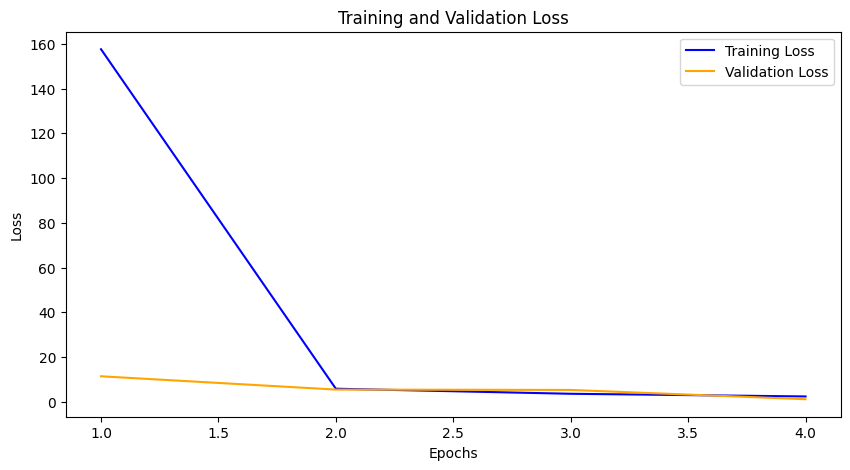

In [42]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 4
save_path = '/kaggle/working/best_model.pth'  

patience = 3  
min_delta = 0.001  
early_stop_counter = 0

best_val_loss = float('inf')  
best_val_acc = 0.0  

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total

    print(f'[{epoch + 1}] train_loss: {avg_train_loss:.3f}, val_loss: {avg_val_loss:.3f}, val_acc: {val_acc:.3f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved at epoch {epoch + 1} with val_acc: {val_acc:.3f}")

    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

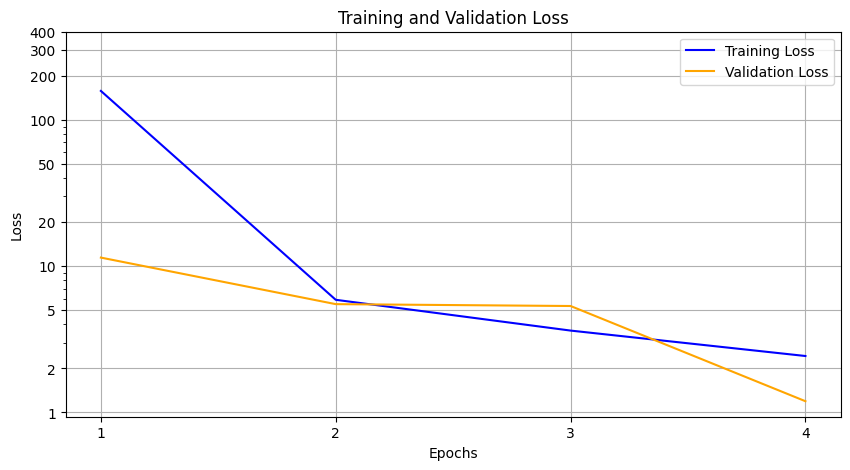

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  

y_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 300, 400]  
plt.yticks(y_ticks, [str(val) for val in y_ticks])  

plt.xticks(range(1, num_epochs + 1)) 
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

TEST ACCURACY,CUSTOM ACCURACY, RECALL PART OF THE BEST MODEL

In [44]:
from torch.utils.data import Subset, DataLoader
import numpy as np

labels_array = [dataset[i][1] for i in range(len(dataset))]

In [51]:
fatal_indices = [i for i, label in enumerate(labels_array) if label == 3]
moderate_indices = [i for i, label in enumerate(labels_array) if label == 1]
severe_indices = [i for i, label in enumerate(labels_array) if label == 2]

np.random.seed(42)
np.random.shuffle(fatal_indices)
np.random.shuffle(moderate_indices)
np.random.shuffle(severe_indices)

num_moderate = 50
num_severe = 14
num_fatal = 25

selected_indices = (
    moderate_indices[:num_moderate] +
    fatal_indices[:num_fatal] +
    severe_indices[:num_severe]
)

test_dataset = Subset(dataset, selected_indices)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [54]:
model.load_state_dict(torch.load(save_path))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = 100 * correct / total
print('Test Accuracy: %.3f' % test_acc)

Test Accuracy: 56.180


In [52]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(model, data_loader, device):
    model.eval()
    correct_predictions = 0
    custom_correct = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # The probabilities from the outputs
            probabilities = torch.softmax(outputs, dim=1)
            top_probs, top_classes = torch.topk(probabilities, 2, dim=1)

            p1 = top_classes[:, 0]  
            p2 = top_classes[:, 1]  

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(p1.cpu().numpy())

            for i in range(len(labels)):
                true_label = labels[i].item()
                predicted1 = p1[i].item()
                predicted2 = p2[i].item()
                
                if abs(predicted1-predicted2) == 1:
                    if(predicted1==true_label or predicted2==true_label):  
                        custom_correct += 1 
                else:
                    if predicted1 == true_label:
                        custom_correct += 1

    total_samples = len(all_labels)
    custom_accuracy = custom_correct / total_samples
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"Custom Accuracy: {custom_accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

In [53]:
model.load_state_dict(torch.load(save_path))
calculate_metrics(model, test_loader, device)

Custom Accuracy: 71.91%
Precision: 0.32
Recall: 0.56
F1 Score: 0.40


In [10]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

test_video_numbers = annotations.iloc[test_indices]['Video Number'].unique()
test_annotations = annotations.iloc[test_indices][['Video Number', 'Severity of the Crash']]
test_annotations = test_annotations.drop_duplicates(subset=['Video Number'])
test_annotations.to_csv('/kaggle/working/test_annotations.csv', index=False)

test_frames_dir = '/kaggle/working/test_frames'
os.makedirs(test_frames_dir, exist_ok=True)

source_frames_dir = '/kaggle/working/frames'

for video_number in tqdm(test_video_numbers, desc='Copying test frames'):
    video_str = f"{video_number:06}"
    src_dir = os.path.join(source_frames_dir, video_str)
    dest_dir = os.path.join(test_frames_dir, video_str)
    
    if os.path.exists(src_dir):
        shutil.copytree(src_dir, dest_dir)

shutil.make_archive('/kaggle/working/test_frames', 'zip', test_frames_dir)
shutil.rmtree(test_frames_dir)

print("Exported files:")
print("- /kaggle/working/test_frames.zip")
print("- /kaggle/working/test_annotations.csv")

Copying test frames: 100%|██████████| 142/142 [00:01<00:00, 136.59it/s]


Exported files:
- /kaggle/working/test_frames.zip
- /kaggle/working/test_annotations.csv


In [11]:
import os

# Delete the test_frames.zip file
zip_path = '/kaggle/working/test_frames.zip'
if os.path.exists(zip_path):
    os.remove(zip_path)
    print(f"Deleted: {zip_path}")
else:
    print("ZIP file not found")

# Optionally: Delete other temporary files (e.g., CSV)
csv_path = '/kaggle/working/test_annotations.csv'
if os.path.exists(csv_path):
    os.remove(csv_path)

Deleted: /kaggle/working/test_frames.zip
